In [27]:
import tensorflow as tf
import os
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [28]:
df = tfds.load('fashion_mnist', split='train')
df.as_numpy_iterator().next()['label']

2

In [29]:
dataiterator = df.as_numpy_iterator()
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

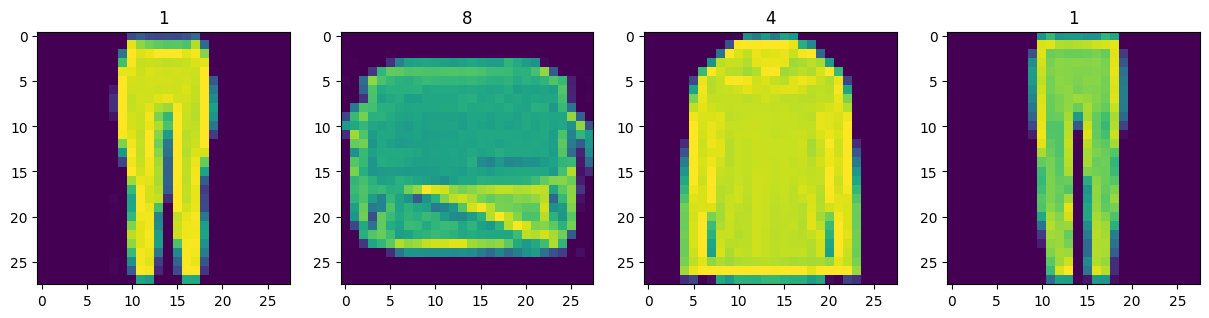

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [31]:
def scale_images(data):
  image = data['image']
  return image / 255

In [32]:
df = tfds.load('fashion_mnist', split='train')
df = df.map(scale_images)
df = df.cache()
df = df.shuffle(60000)
df = df.batch(128)
df = df.prefetch(64)
df.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [33]:
def generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
  return model

In [34]:
generator = generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 114ms/step


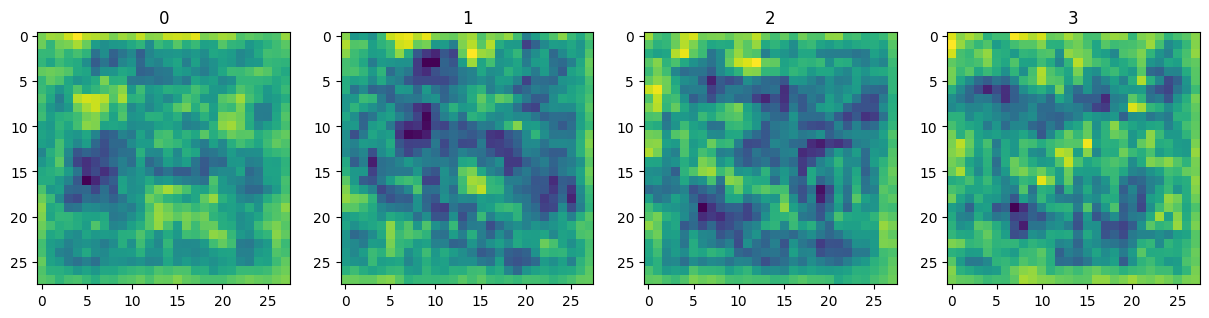

In [35]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [36]:
def discriminator():
  model = Sequential()
  model.add(Conv2D(32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [37]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [38]:
img = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img)

1/1 [==============================] - 0s 102ms/step


array([[0.4984994 ],
       [0.49876863],
       [0.49855757],
       [0.49848244]], dtype=float32)

In [39]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [40]:
class GAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss= g_loss
    self.d_loss = d_loss

  def train_step(self,batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)
    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
      predicted_labels = self.discriminator(gen_images, training=False)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [41]:
gan = GAN(generator, discriminator)

In [42]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [43]:
hist = gan.fit(df, epochs=60)

Epoch 1/60
469/469 [==============================] - 130s 163ms/step - d_loss: 0.4852 - g_loss: 1.1519
Epoch 2/60
469/469 [==============================] - 77s 164ms/step - d_loss: 0.5441 - g_loss: 2.9839
Epoch 3/60
469/469 [==============================] - 77s 164ms/step - d_loss: 0.7003 - g_loss: 0.6529
Epoch 4/60
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6801 - g_loss: 0.6599
Epoch 5/60
469/469 [==============================] - 77s 165ms/step - d_loss: 0.5845 - g_loss: 1.3331
Epoch 6/60
469/469 [==============================] - 77s 164ms/step - d_loss: 0.4031 - g_loss: 0.1036
Epoch 7/60
469/469 [==============================] - 77s 164ms/step - d_loss: 0.5528 - g_loss: 0.1336
Epoch 8/60
469/469 [==============================] - 77s 165ms/step - d_loss: 0.7031 - g_loss: 0.5923
Epoch 9/60
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6683 - g_loss: 0.5759
Epoch 10/60
469/469 [==============================] - 77s 164ms/step - 

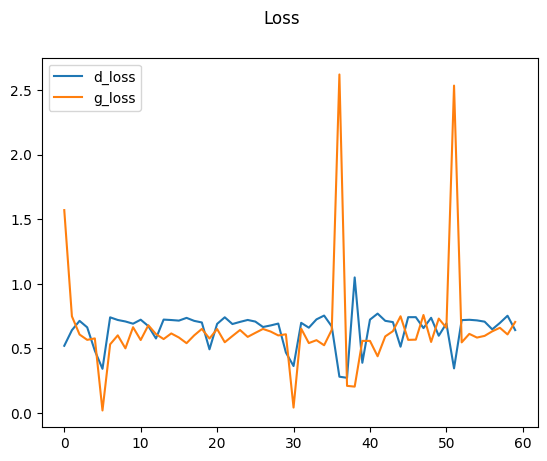

In [44]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [45]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 439ms/step


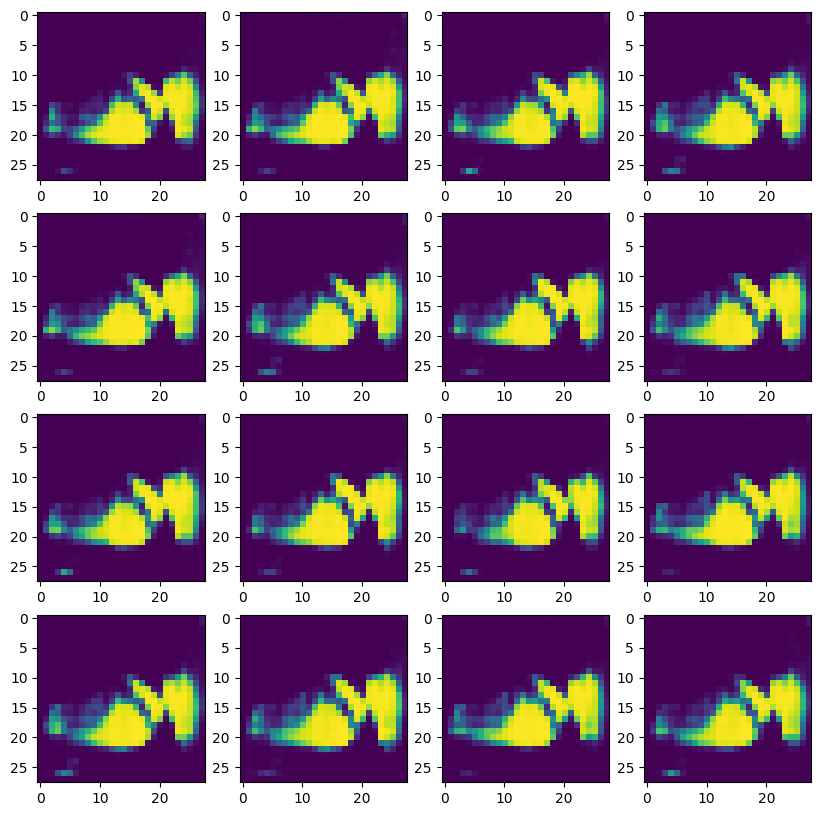

In [46]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [48]:
generator.save('generator.keras')
discriminator.save('discriminator.keras')